# 3장 DT(Decision Tree)

<img src="img/1.PNG" />

#### 장점
- 계산 비용이 적다.
- 학습된 결과를 사람이 이해하기 쉬우며 누락된 값(missing values)이 있어도 처리할 수 있다.
- 분류와 관련이 없는 속성이 있어도 처리할 수 있다.

#### 단점
- 과적합(overfitting)되기 쉽다.

#### 적용
- 수치형 값, 명목형 값

#### 목차
 3.1 트리 구조<br/>
 3.2 매스플롯라이브러리 주석으로 파이썬에서 트리 플롯하기<br/>
 3.3 분류기 검사와 저장<br/>
 3.4 예제: 콘택트렌즈 유형 예측하기<br/>
 3.5 예제: 000<br/>
 
 
<br/><br/>
## 3.1 트리 구조
<img src="img/2.png" />

- 정보 이론(information theory)을 이용하여 데이터 집합을 어떻게 분할하는지에 대한 수학적인 방법을 논할 것
- 데이터 집합을 처리하는 데 이 이론을 적용하기 위하여 코드를 작성할 것
- 트리를 만들기 위한 코드를 작성할 것


### 3.1.1 정보 이득

#### 정보 이득(information gain)
- 데이터를 분할하기 전과 후의 변화
- 어떤 속성으로 데이터를 분할할 때, 가장 높은 정보 이득을 취할 수 있는지 확인 가능함
- 정보 이득이 가장 높은 속성을 가지고 분할하는 것이 가장 좋은 선택임

#### 섀넌 엔트로피(Shannon entropy)
- 데이터 집합에 대한 정보 측정 방법
- 엔트로피가 더 높다는 것은 데이터가 그만큼 더 혼잡하다는 것을 뜻함
- <img src="img/3.png" />

In [94]:
from math import log

# calShannonEnt 함수
# dataSet: 엔트로피 계산을 원하는 데이터 집합
# shannonEnt: 엔트로피 값
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # 가능한 모든 분류 항목에 대한 딕셔너리 생성
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    # 섀넌 엔트로피 계산
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)  # 밑수가 2인 로그
    return shannonEnt

In [95]:
# createDataSet 함수
# dataSet: 데이터 집합
# labels: 속성 집합
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

# calShannonEnt 사용 예제
myDat, labels = createDataSet()
print myDat
print " = %f" % calcShannonEnt(myDat)
myDat[0][-1] = 'maybe'
print myDat
print " = %f" % calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
 = 0.970951
[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
 = 1.370951


### 3.1.2 데이터 집합 분할하기

In [96]:
# splitDataSet 함수
# dataSet: 분할하고자 하는 데이터 집합
# axis: 분할하고자 하는 속성
# value: 반환할 속성의 값
# retDataSet: 분할된 데이터 집합
def splitDataSet(dataSet, axis, value):
    retDataSet = []  # 분할 리스트 생성
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [97]:
# append, extend 차이
a=[1, 2, 3]
b=[4, 5, 6]

a.append(b)
print a

a=[1, 2, 3]
a.extend(b)
print a

[1, 2, 3, [4, 5, 6]]
[1, 2, 3, 4, 5, 6]


In [98]:
# splitDataSet 사용 예제
myDat, labels = createDataSet()
print myDat
print splitDataSet(myDat, 0, 1)
print splitDataSet(myDat, 0, 0)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


In [99]:
# chooseBestFeatureToSplit 함수
# dataSet: 데이터 집합
# bestFeature: 가장 정보 이득이 큰 속성
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1  # 속성 개수
    baseEntropy = calcShannonEnt(dataSet)  # 분할 전 데이터 집합의 엔트로피
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)  # 분류 항목 표시에 대해 중복이 없는 리스트 생성
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)  # 각각의 분할을 위해 엔트로피 계산
        infoGain = baseEntropy - newEntropy
        if(infoGain > bestInfoGain):  # 가장 큰 정보 이득 찾기
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [100]:
# chooseBestFeatureToSplit 사용 예제
myDat, labels = createDataSet()
print "Best feature is %d" % chooseBestFeatureToSplit(myDat)

Best feature is 0


### 3.1.3 재귀적으로 트리 만들기

####  종료 조건
- 하나의 가지에 있는 모든 사례가 전부 같은 분류 항목일 때 -> 해당 분류 항목 반환
- 더 이상 분할할 속성이 없을 때 -> 다수결

<img src="img/4.png" />

In [101]:
# majorityCnt 함수
# classList: 클래스 리스트
# sortedClassCount[0][0]: 가장 많은 클래스 종류
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)  # count 횟수로 내림차순 정렬
    return sortedClassCount[0][0]

In [102]:
# createTree 함수
# dataSet: 데이터 집합
# labels: 속성 집합
# myTree: 트리
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):  # 모든 분류 항목이 같을 때 멈춤
        return classList[0]
    if len(dataSet[0]) == 1:  # 속성이 더 이상 없을 때 가장 많은 수를 반환함
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)  # 최적 속성 찾기
    bestFeatLabel = labels[bestFeat]  # 최적 속성 이름 저장
    myTree = {bestFeatLabel:{}}  # 가지 추가
    del(labels[bestFeat]) # 분류된 집합 제거
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)  # 유일한 값의 리스트를 구함
    for value in uniqueVals:
        subLabels = labels[:] # 중첩이 이루어지기 전에 복사물을 만듬
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)  # 재귀 결과 트리 추가
    return myTree

In [103]:
# createTree 사용 예제
MyDat, labels = createDataSet()
print myDat
print labels

myTree = createTree(myDat, labels)
print myTree

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## 3.2 매스플롯라이브러리 주석으로 파이썬에서 트리 플롯하기

- 기존에 만든 트리는 시작적으로 보기 어려움
- 매스플롯라이브러리를 사용하여 트리로 시각화하고자 함

<img src="img/5.PNG" />


### 3.2.1 매스플롯라이브러리 주석

- 매스플롯라이브러리는 텍스트에 가까운 데이터를 추가할 수 있어 주석이라고 불릴 정도로 훌륭한 도구임

<img src="img/6.PNG" />

In [104]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")  # 상자 형태 정의 (상자 모양, 색)
leafNode = dict(boxstyle="round4", fc="0.8")  # 상자 형태 정의 (상자 모양, 색)
arrow_args = dict(arrowstyle="<-")  # 화살표 형태 정의 (화살표 모양)

# plotNode 함수
# nodeTxt:노드 텍스트
# centerPt: 자식 위치 
# parentPt: 부모 위치
# nodeType: 노드 종류
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    # 주석 달기 (http://matplotlib.org/users/annotations_intro.html)
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType,
                            arrowprops=arrow_args)
    # nodeTxt: text
    # xy: start point
    # xycoords: coordinate of xy (0,0 is lower left of axes and 1,1 is upper right)
    # xytext: text point
    # textcoords: coordinate of test (0,0 is lower left of axes and 1,1 is upper right)
    # bbox: box border
    # arrowprops: arrow propery
    

# createPlot 함수
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()  # clearfigure
    createPlot.ax1 = plt.subplot(111, frameon=False)  # createPlot은 전역변수
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

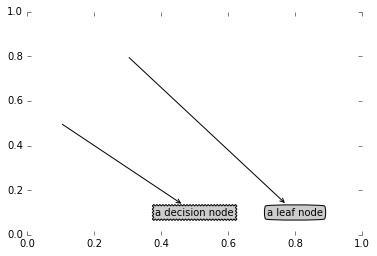

In [105]:
%matplotlib inline

# createPlot 사용 예제
createPlot()

### 3.2.2 주석 트리 구축하기


In [106]:
# getNumLeafs 함수
# myTree: 트리 (dictionary)
# numLeafs: 트리의 노드 개수
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':  # 노드가 Dictionary이면 의사결정 영역
            numLeafs += getNumLeafs(secondDict[key])  # 재귀
        else: numLeafs += 1  # 아니면 단말 영역
    return numLeafs

# getTreeDepth 함수
# myTree: 트리 (dictionary)
# numLeafs: 트리의 깊이
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':  # 노드가 Dictionary이면 의사결정 영역
            thisDepth = 1 + getTreeDepth(secondDict[key])  # 재귀
        else: thisDepth = 1  # 아니면 단말 영역
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

# retrieveTree 함수
# i: 트리 종류
# listOfTrees[i]: i번째 트리 예제
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [107]:
myTree = retrieveTree(0)
print "Tree="
print myTree
print "Number of leafs="
print getNumLeafs(myTree)
print "Depth of tree="
print getTreeDepth(myTree)

Tree=
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
Number of leafs=
3
Depth of tree=
2


In [108]:
# plotMidText 함수
# cntrPt: 자식 노드 위치
# parentPt: 부모 노드 위치
# txtString: 문자열
def plotMidText(cntrPt, parentPt, txtString):
    # 자식 노드와 부모 노드 사이에 텍스트 플롯하기
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

    # plotTree 함수
# myTree: 트리 (dictionary)
# parentPt: 부모 노드 위치
# nodeTxt: 문자열
def plotTree(myTree, parentPt, nodeTxt):
    # 트리의 넓이와 높이를 계산함
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0] 
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  # 자식 노드 값 플롯하기
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD  # y offset 감소
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':  # 노드가 Dictionary이면 의사결정 영역
            plotTree(secondDict[key],cntrPt,str(key))  # 재귀
        else:  # 아니면 단말 영역
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

# createPlot 함수
# inTree: 트리 (dictionary)
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


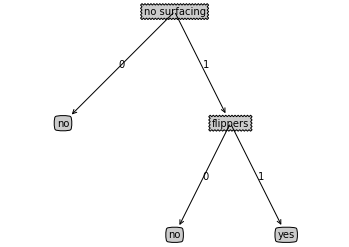

In [109]:
%matplotlib inline

myTree = retrieveTree(0)
print myTree
createPlot(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}


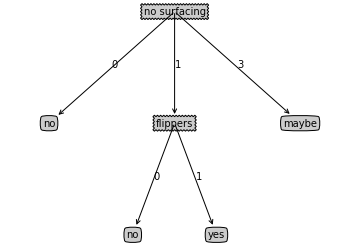

In [110]:
%matplotlib inline

myTree['no surfacing'][3] = 'maybe'
print myTree
createPlot(myTree)

## 3.3 분류기 검사와 저장

### 3.3.1 검사: 분류를 위한 트리 사용

In [111]:
# classify 함수
# inputTree: 트리 (dictionary)
# featLabels: 라벨
# testVec: testSet
# classLabel: 분류된 라벨
def classify(inputTree, featLabels, testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)  # 색인을 위한 분류 항목 표시 문자열 변환
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else: classLabel = secondDict[key]
    return classLabel

In [112]:
myDat, labels = createDataSet()
myTree = retrieveTree(0)
print myDat
print labels
print myTree
print classify(myTree, labels, [1,0])
print classify(myTree, labels, [1,1])

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


### 3.3.2 사용: 의사결정 트리 계속 유지하기
- 매번 트리를 새로 만드는 것은 비효율적임
- 한번 만든 트리를 유지하면 효율적임

In [113]:
# storeTree 함수
# inputTree: 저장할 트리 객체
# filename: 저장할 파일 이름
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)  # 객체 저장
    fw.close()
    
# grabTree 함수
# filename: 로드할 파일 이름ㄹ
# pickle.load(fr): 로드된 트리 객체
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)  # 객체 로드

In [114]:
storeTree(myTree, 'data\classifierStorage.txt')
grabTree('data\classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 3.4 예제: 콘택트렌즈 유형 예측하기
- 미리 처방된 콘택트렌즈의 유형을 예측하는 예제
- class: 하드(hard), 소프트(soft), 없음(no)

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses', 'presbyopic': 'no lenses', 'young': 'hard'}}, 'myope': 'hard'}}, 'no': {'age': {'pre': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'young': 'soft'}}}}}}


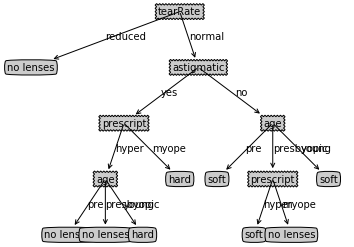

In [115]:
fr = open('data\lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
print lensesTree
createPlot(lensesTree)

- 의사결정 트리가 데이터에 너무 잘 일치한다는 것은 과적합(overfitting)이라고 함
- 데이터에 너무 종속적임
- 따라서 추후 과적합 문제를 줄이기 위해 트리를 가지치기(prune)할 수 있음